In [1]:
import gym
import torch
import warnings
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [2]:
class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, gamma=0.99, lr=1e-3):
        super(PPO, self).__init__()
        self.data = []
        self.gamma = gamma
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # GAE 파라미터
        self.lmbda = 0.95
        self.eps = 0.1
        self.K = 3

        self.fc1 = nn.Linear(state_dim, 64).to(self.device)
        self.fc2 = nn.Linear(64, 32).to(self.device)
        self.fc_pi = nn.Linear(32, action_dim).to(self.device)
        self.fc_v = nn.Linear(32, 1).to(self.device)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def pi(self, x, softmax_dim=-1):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc_pi(x)
        prob = F.softmax(x, dim=softmax_dim)
        return prob

    def v(self, x):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        v = self.fc_v(x)
        return v

    def select_action(self, state, rewards_log):
        state_tensor = torch.FloatTensor(state).to(self.device)
        probs = self.pi(state_tensor)

        # 최근 10개의 평균 reward가 450 이상이면 best action 선택
        if len(rewards_log) >= 10 and np.mean(rewards_log[-10:]) >= 450:
            action = torch.argmax(probs)
            action_prob = probs[action].detach().item()

        else:
            distribution = torch.distributions.Categorical(probs)
            action = distribution.sample()
            action_prob = probs[action].detach().item()

        return action.item(), action_prob

    def put_data(self, item):
        self.data.append(item)

    def make_batch(self):
        s_lst, a_lst, r_lst, s_prime_lst, prob_a_lst, done_lst = [], [], [], [], [], []
        for item in self.data:
            s, a, r, s_prime, prob_a, done = item
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            prob_a_lst.append([prob_a])
            done_lst.append([0 if done else 1])

        # 텐서 변환 후 device로 이동
        s = torch.tensor(s_lst, dtype=torch.float).to(self.device)
        a = torch.tensor(a_lst).to(self.device)
        r = torch.tensor(r_lst).to(self.device)
        s_prime = torch.tensor(s_prime_lst, dtype=torch.float).to(self.device)
        done_mask = torch.tensor(done_lst, dtype=torch.float).to(self.device)
        prob_a = torch.tensor(prob_a_lst).to(self.device)

        self.data = []
        return s, a, r, s_prime, done_mask, prob_a

    def train(self):
        s, a, r, s_prime, done_mask, prob_a = self.make_batch()

        for _ in range(self.K):
            td_target = r + self.gamma * self.v(s_prime) * done_mask
            delta = td_target - self.v(s)
            delta = delta.detach().cpu().numpy()  # numpy 연산을 위해 CPU로 이동

            advantage_lst = []
            advantage = 0
            for delta_t in delta[::-1]:
                advantage = self.gamma * self.lmbda * advantage + delta_t[0]
                advantage_lst.append([advantage])
            advantage_lst.reverse()

            advantage = torch.tensor(advantage_lst, dtype=torch.float).to(self.device)

            pi = self.pi(s, softmax_dim=-1)
            pi_a = pi.gather(1, a)
            ratio = torch.exp(torch.log(pi_a) - torch.log(prob_a))

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            loss = -torch.min(surr1, surr2) + F.smooth_l1_loss(td_target.detach(), self.v(s))

            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()

In [3]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='leaky_relu')


def plot_weight_distribution(model):
    plt.figure(figsize=(12, 4), dpi=400)

    for name, param in model.named_parameters():
        if "weight" in name:
            sns.histplot(param.data.cpu().numpy().flatten(), bins=100, kde=True, label=name)

    plt.title("Weight Distribution of DQN")
    plt.xlabel("Weight Values")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [ ]:
# 환경 설정
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

model = PPO(state_dim=state_dim, action_dim=action_dim)
model.fc1.apply(initialize_weights)
model.fc2.apply(initialize_weights)

T = 500  # T는 몇 타임스탭 동안 data를 모을지
rewards_log = []

for n_epi in tqdm(range(1000)):
    s, _ = env.reset()
    total_reward = 0.0
    step_count = 0

    for t in range(T):
        a, prob = model.select_action(s, rewards_log)
        s_prime, r, terminated, truncated, info = env.step(a)
        done = truncated or terminated

        decreasing_reward = r * (0.99 ** step_count)
        step_count += 1

        # prob -> 실제 한 action의 확률값 나중에 ratio 계산에 쓰임
        # 나중에 PPO에서 old policy 의 확률값 사용함.
        model.put_data((s, a, decreasing_reward, s_prime, prob, done))
        s = s_prime

        total_reward += r

        if done:
            break

    if np.mean(rewards_log[-10:]) < 450:
        model.train()

    rewards_log.append(total_reward)

env.close()

 10%|▉         | 97/1000 [00:05<01:38,  9.20it/s]

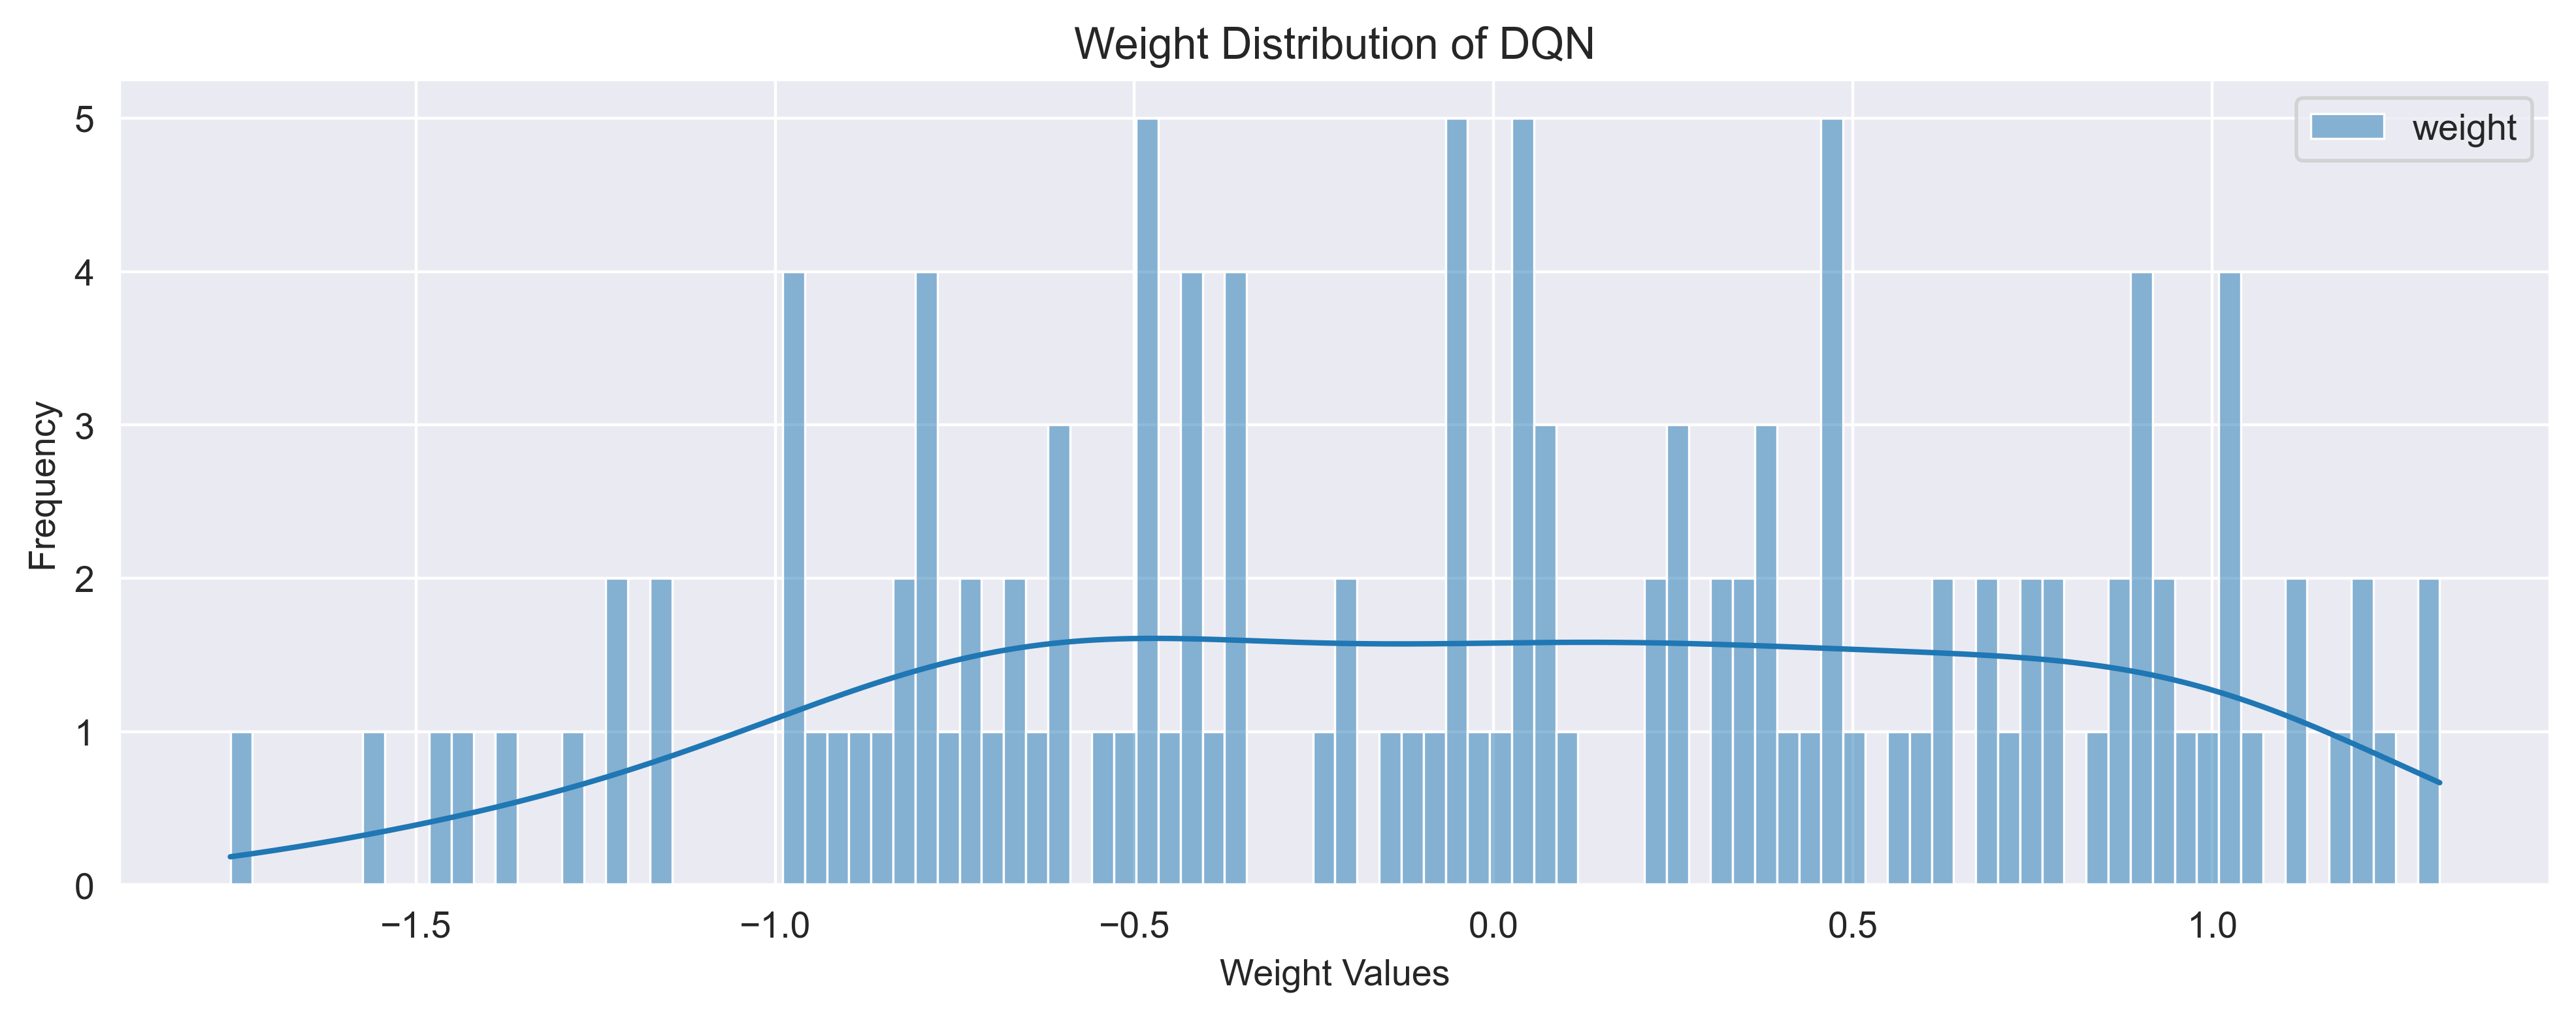

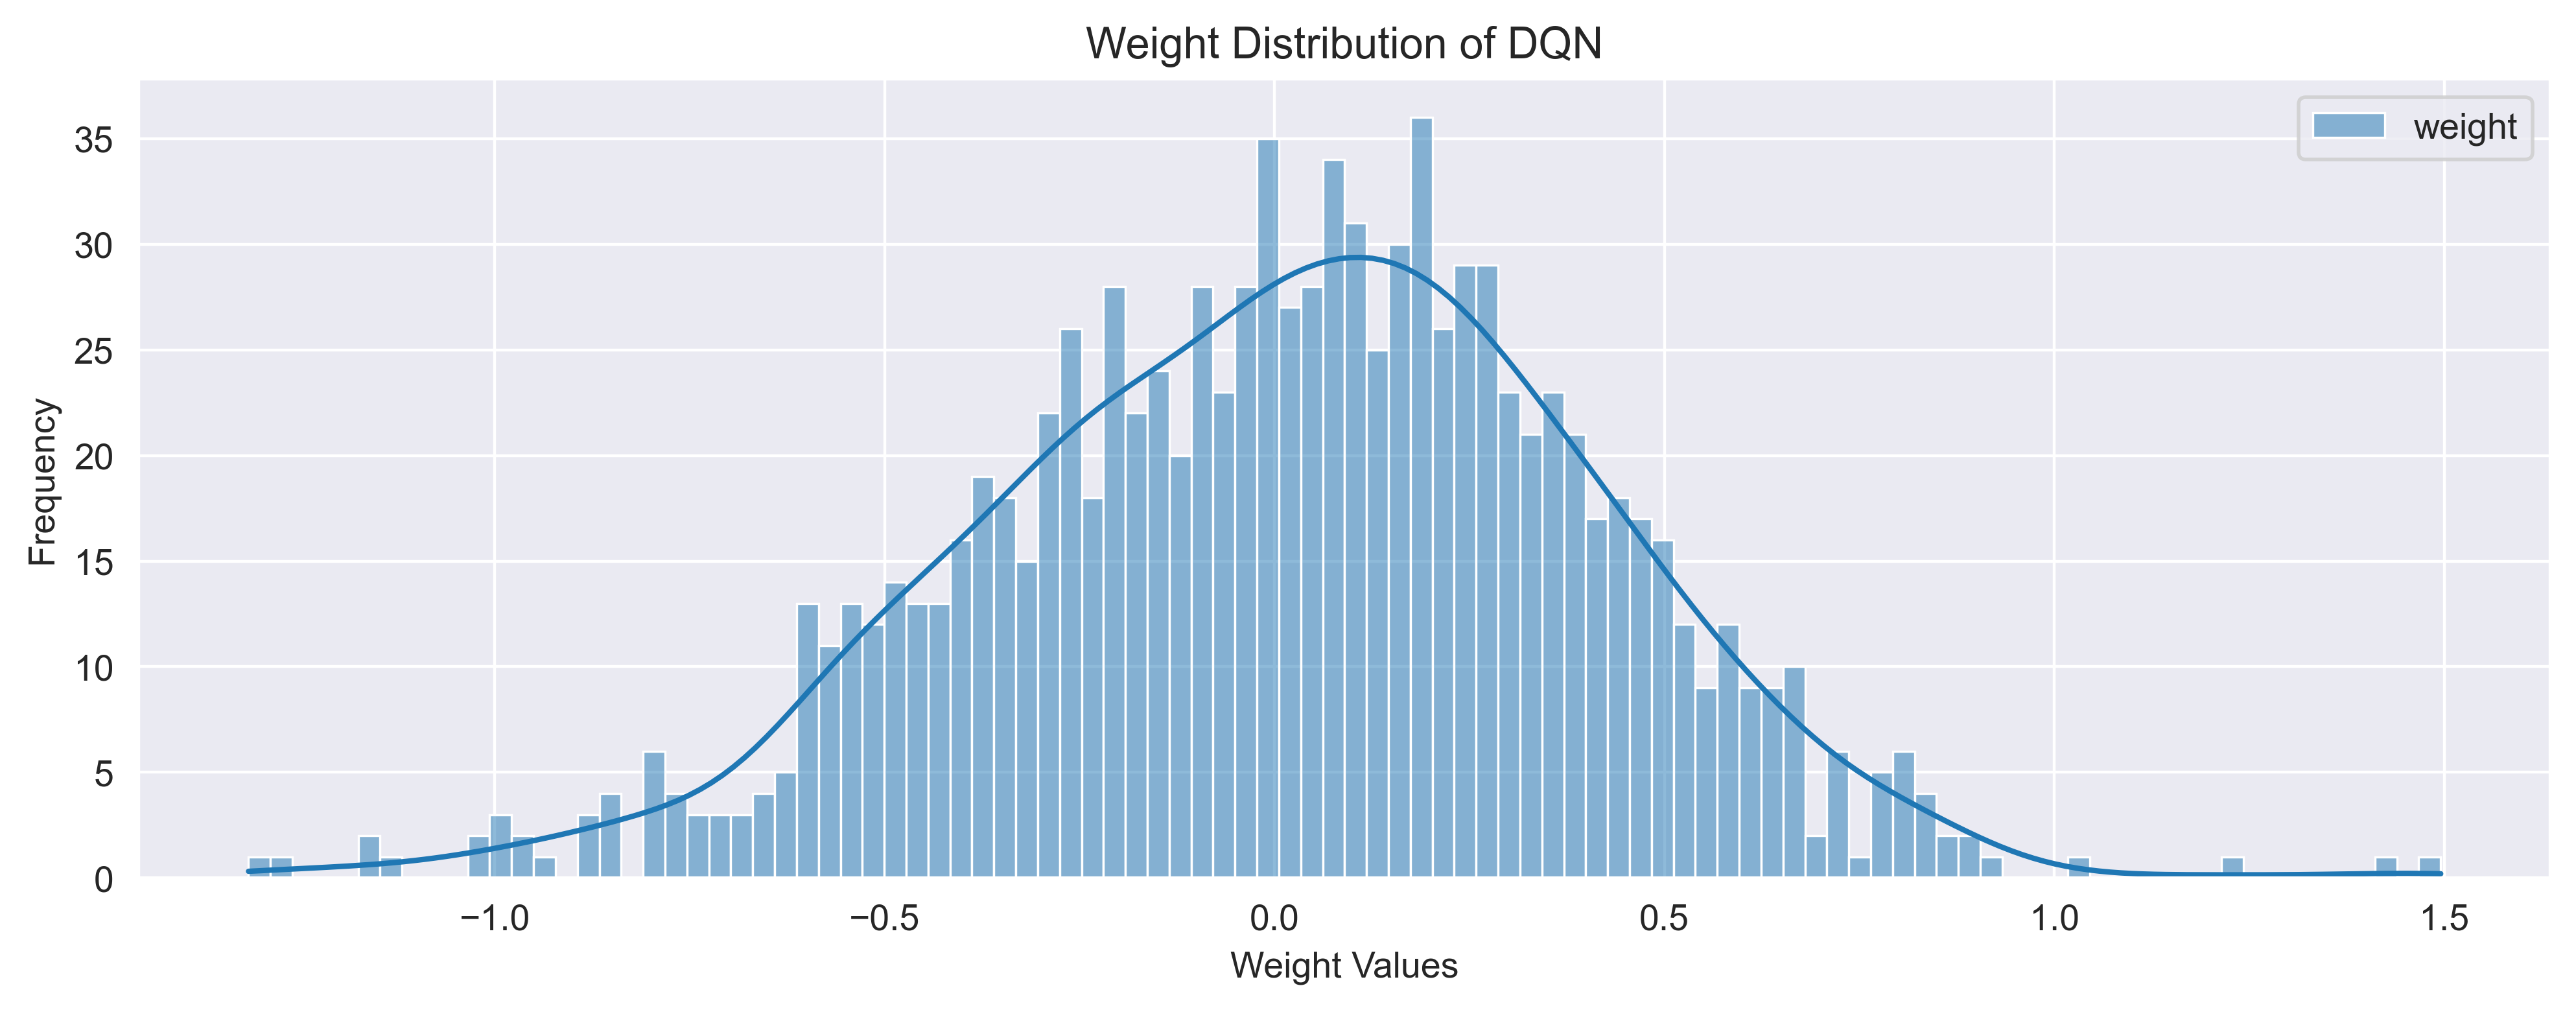

In [5]:
# 현재 policy_net의 가중치 분포 확인
plot_weight_distribution(model.fc1)
plot_weight_distribution(model.fc2)

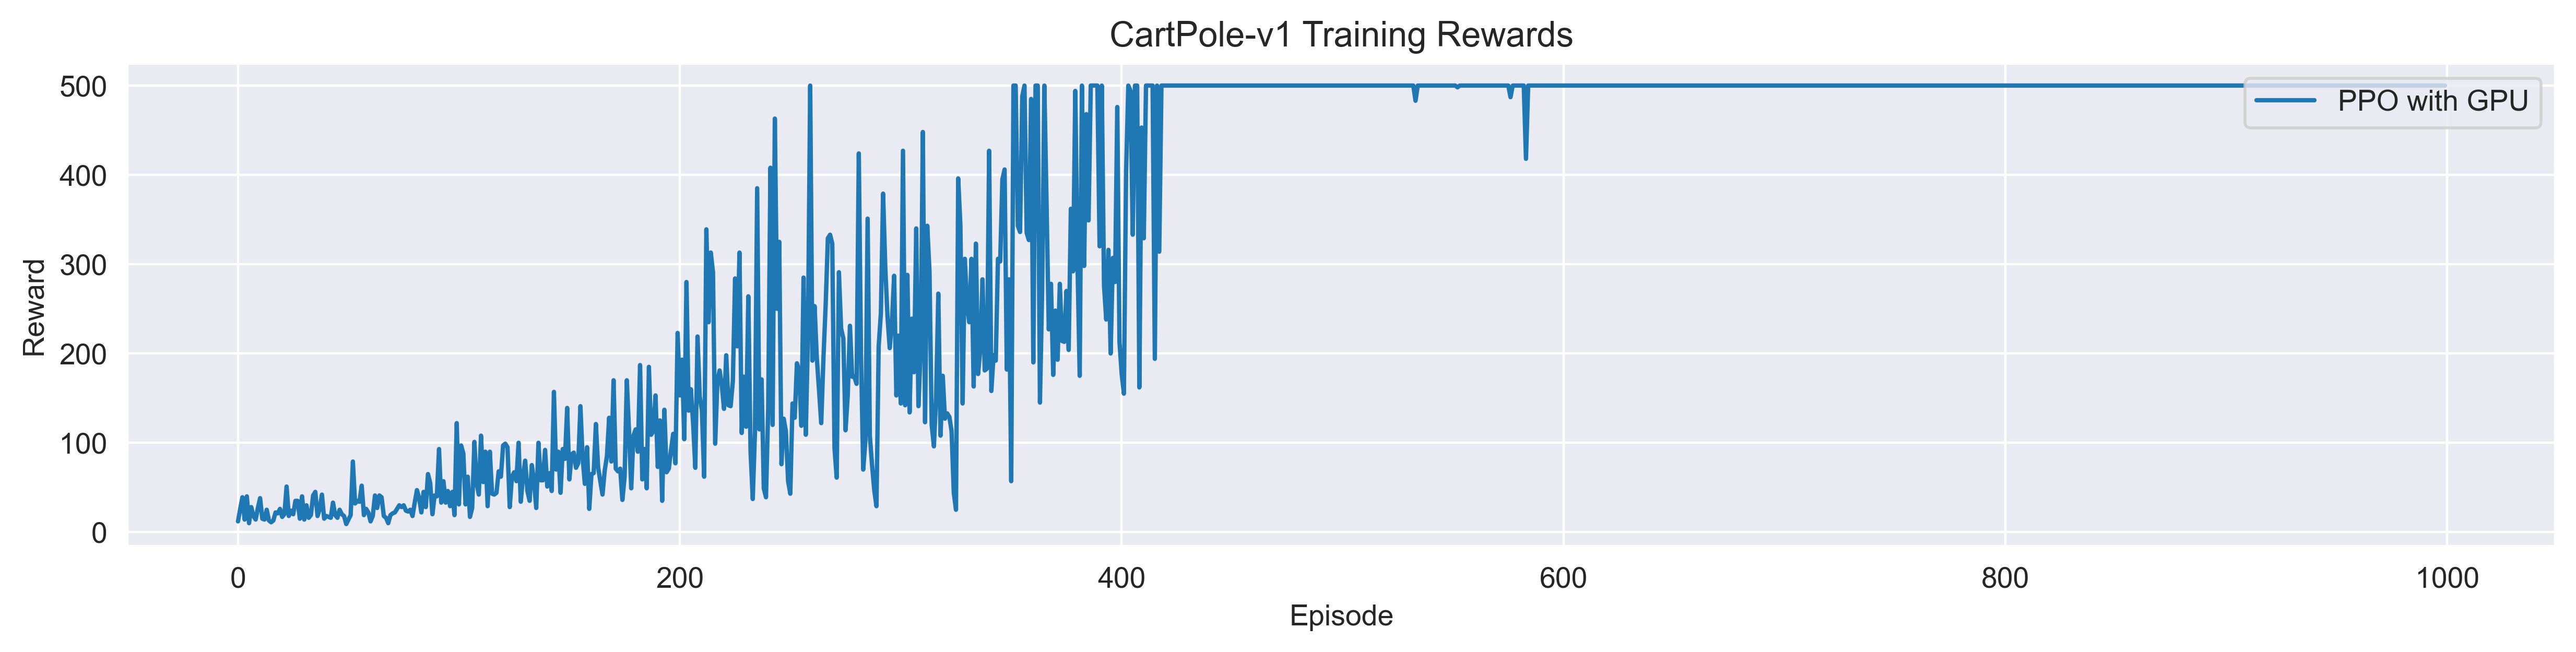

First 10 episode rewards: [12.0, 26.0, 39.0, 14.0, 40.0, 10.0, 28.0, 18.0, 14.0, 27.0]
Last 10 episode rewards: [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Average reward over last 100 episodes: 500.00


In [6]:
# 학습 결과 시각화
plt.figure(figsize=(15, 3), dpi=400)
plt.plot(rewards_log, label="PPO with GPU")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("CartPole-v1 Training Rewards")
plt.legend(loc="upper right")
plt.show()

print("First 10 episode rewards:", rewards_log[:10])
print("Last 10 episode rewards:", rewards_log[-10:])
print(f"Average reward over last 100 episodes: {np.mean(rewards_log[-100:]):.2f}")